In [100]:
import os
import toml
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import copy
import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional

from preproc import import_csv, new_hybrid_interpolator
from customobjs import objdict

In [192]:
def dist_plot(series: pd.core.series.Series, dropna: bool = True, sig: Optional[int] = None) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    sig = sig or 0
    
    
    quarts = scipy.stats.mstats.mquantiles(series, [0.001, 0.25, 0.5, 0.75, 0.975])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_hist.axvline(series.mean())
    ax_hist.set_xticks(quarts)
    #ax_box.set(xlabel=f'Mean value : {int(series.mean())}')
    plt.title(f"Glycaemic Distribution μ = {round(series.mean(), sig)}, σ = {round(series.std(), sig)}")
##

def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "mean"
) -> NoReturn:
    """ 
    """
    
    glc_to_hba1c = lambda x: (x + 105) / 36.5
    hba1c_to_glc = lambda x: x*36.5 - 105 
    valid_kinds = ["mean", "std", "var", "median"]
    
    if kind in valid_kinds:
        df.groupby(df.index.date)[colum_name].\
            apply(eval(f"pd.Series.{kind}")).apply(hba1c).\
                plot(**{"label":"daily"})
                
        for key, value in windows.items():
            ax = df.groupby(df.index.date)[colum_name].\
                    apply(eval(f"pd.Series.{kind}")).rolling(value).mean().\
                            apply(hba1c).plot(**{"label":key})
    
        ax.set_ylabel("HbA1c %")
        mean_hba1c = glc_to_hba1c(eval(f"df[colum_name].{kind}()"))
        secax = ax.secondary_yaxis('right', functions=(hba1c_to_glc, glc_to_hba1c))
        secax.set_ylabel('mg/dL')
        plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
        plt.legend()
        plt.title(f"Average {kind} of {colum_name}")
    else:
        raise Exception(f"kind should be one of {valid_kinds}")
##

def proportions_visualiser(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    limits: Dict[str,int] = {
        "low": 70,
        "high": 180
    },
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "TIR"
) -> NoReturn:
    """
        Wuhuuuu
    """
    
    valid_kinds = ["TIR", "TBR", "TAR"]
    titles = {
        "TIR": f"Time In Range [{limits['low']},{limits['high']})",
        "TAR": f"Time Above Range >= {limits['high']}",
        "TBR": f"Time Below Range < {limits['low']}"
    }
    
    kind = kind.upper()
    
    if kind not in valid_kinds:
        raise Exception(f"Invalid kind `{kind}`, select one from {valid_kinds}")
    
    TIR = lambda y: 100 * y[ (y >= limits["low"]) & (y < limits["high"]) ].count() / y.count()
    TBR = lambda y: 100 * y[ (y < limits["low"]) ].count() / y.count()
    TAR = lambda y: 100 * y[ (y >= limits["high"]) ].count() / y.count()
    
    _proportions = df["Sensor Glucose (mg/dL)"].groupby(data.index.date).apply(eval(f"{kind}"))
    
    _proportions.plot(**{"label": "daily"})
    
    for key, value in windows.items():
        _ax = _proportions.rolling(value).mean().plot(**{"label":key})
    
    _mean_proportion = _proportions.mean()
    plt.ylabel("Percentage")
    plt.axhline(_mean_proportion, **{"label": f"mean = {round(_mean_proportion,1)}", "c": "blue"})
    plt.legend()
    plt.title(titles[kind])
##    

def nonull_indices(
    df: pd.DataFrame,
    column: str
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """  
    _nonull = df[column].dropna()
    _nonull = _nonull[ _nonull > 0 ]
    return _nonull.index
##

def bolus_indices(
    df: pd.DataFrame, 
    columns: Optional[List[str]] = None
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """
    
    columns = columns or ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    _nonull = partial(nonull_indices, df)
    indices_ls = list(map(_nonull, columns))
    return reduce(lambda x, y: x.union(y), indices_ls)
##


def basal_only(df: pd.DataFrame, column: str = "Sensor Glucose (mg/dL)") -> pd.DataFrame:
    """
    """
    basal = df.copy()
    for uid in bolus_indices(basal):
        real = uid+dt.timedelta(hours=2, minutes=30)
        closest = df.index[df.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
        basal.loc[uid:closest, column] = np.nan
    return basal
##

def hourly_trends(df: pd.DataFrame, kind: str = "mean", deltas: Optional[List[int]] = None) -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var", "median"]
    deltas = deltas or [15, 30, 60, 120]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}']\
                .apply(eval(f"np.{kind}"))\
                    .plot(label=f"{i} ") 
            for i in deltas
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##        

In [3]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [11]:
!ls interpolated/ | grep 05-20 | grep 9-06

NG1988812H_Maganna_Gustavo_(13-05-20)_(9-06-20)_interpolated.csv
NG1988812H_Maganna_Gustavo_(27-05-20)_(9-06-20)_interpolated.csv


In [151]:
data = import_csv("interpolated/NG1988812H_Maganna_Gustavo_(27-05-20)_(9-06-20)_interpolated.csv")

/home/gml/.cache/pypoetry/virtualenvs/diabetes-analysis-lNCkfS_0-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,32) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [68]:
data.columns

Index(['New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'Preset Bol

In [194]:
deltas = [1, 15, 30, 60, 120]
woo = pd.DataFrame()
woo

""


In [179]:
def compute_time_periodicity(df: pd.DataFrame) -> NoReturn:
    """
    """
    # Coulmns to capture daily periodicity :
    T = 1439
    min_res_t_series = pd.Series(df.index.hour*60 + df.index.minute)
    _tmp = pd.DataFrame({
        'hour': df.index.hour,
        'minute': min_res_t_series,
        'x(t)': min_res_t_series.apply(lambda x: np.cos(2*np.pi*x / T)),
        'y(t)': min_res_t_series.apply(lambda x: np.sin(2*np.pi*x / T))
    })
    _tmp.index = df.index
    return _tmp
##

In [170]:
pd.Series(data.index.hour*60 + data.index.minute).apply(lambda x: np.sin(2*np.pi*x / 1439))

0        0.348395
1        0.344299
2        0.340196
3        0.336087
4        0.331971
           ...   
21482    0.765030
21483    0.762211
21484    0.759377
21485    0.756529
21486    0.753666
Name: DateTime, Length: 21487, dtype: float64

In [187]:
data = data.drop(["x(t)", "y(t)", "minute", "hour"], axis="columns")
fuckme = compute_time_periodicity(data)
data = data.join(fuckme)

In [188]:
data

,New Device Time,BG Reading (mg/dL),Linked BG Meter ID,Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),Bolus Type,Bolus Volume Selected (U),Bolus Volume Delivered (U),...,Bolus Source,Network Device Associated Reason,Network Device Disassociated Reason,Network Device Disconnected Reason,Sensor Exception,Preset Temp Basal Name,hour,minute,x(t),y(t)
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-05-25 10:38:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10,638,-0.937348,0.348395
2020-05-25 10:39:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10,639,-0.938860,0.344299
2020-05-25 10:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10,640,-0.940355,0.340196
2020-05-25 10:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10,641,-0.941831,0.336087
2020-05-25 10:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10,642,-0.943290,0.331971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-09 08:40:00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8,520,-0.643995,0.765030
2020-06-09 08:41:00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8,521,-0.647329,0.762211
2020-06-09 08:42:00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8,522,-0.650651,0.759377


In [150]:
#pd.concat([data, compute_time_periodicity(data)], axis="columns")

,New Device Time,BG Reading (mg/dL),Linked BG Meter ID,Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),Bolus Type,Bolus Volume Selected (U),Bolus Volume Delivered (U),...,Sensor Exception,Preset Temp Basal Name,hour,minutes,x(t),y(t),hour,minute,x(t),y(t)
1970-01-01 00:00:00.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-09 08:40:00.000000000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-09 08:41:00.000000000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-09 08:42:00.000000000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-09 08:43:00.000000000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
for i in deltas:
    woo[f"d{i}"] = data["Sensor Glucose (mg/dL)"].diff(i)

In [196]:
data  = data.join(woo)

In [163]:
data["Sensor Glucose (mg/dL)"].dropna().shape, data.shape

((20043,), (21487, 48))

In [89]:
# sns.distplot(woo.d30)

In [153]:
print("start \t:", data.index[0])
print("end \t:", data.index[-1])

start 	: 2020-05-25 10:38:00
end 	: 2020-06-09 08:44:00


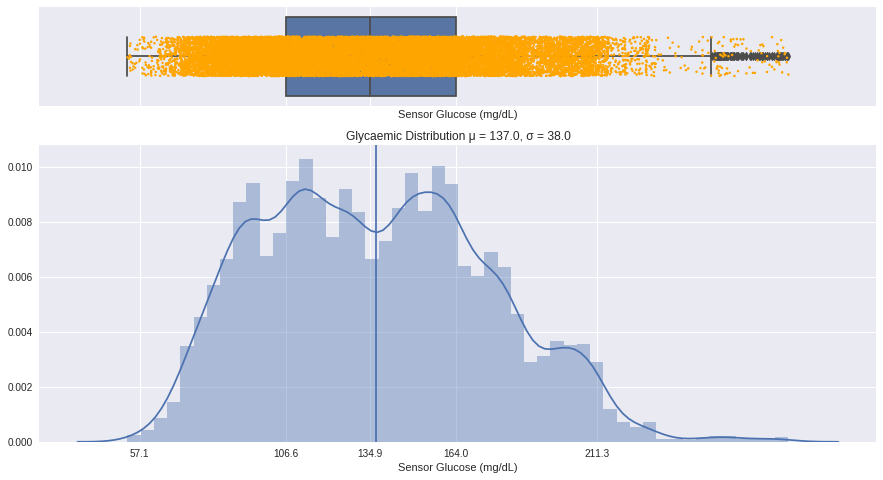

In [152]:
dist_plot(data["Sensor Glucose (mg/dL)"])

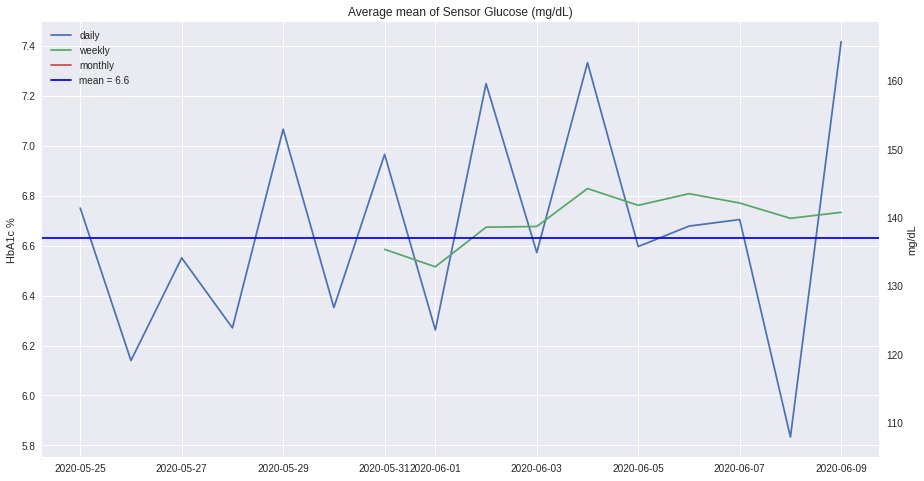

In [17]:
comparative_hba1c_plot(data, kind="mean")

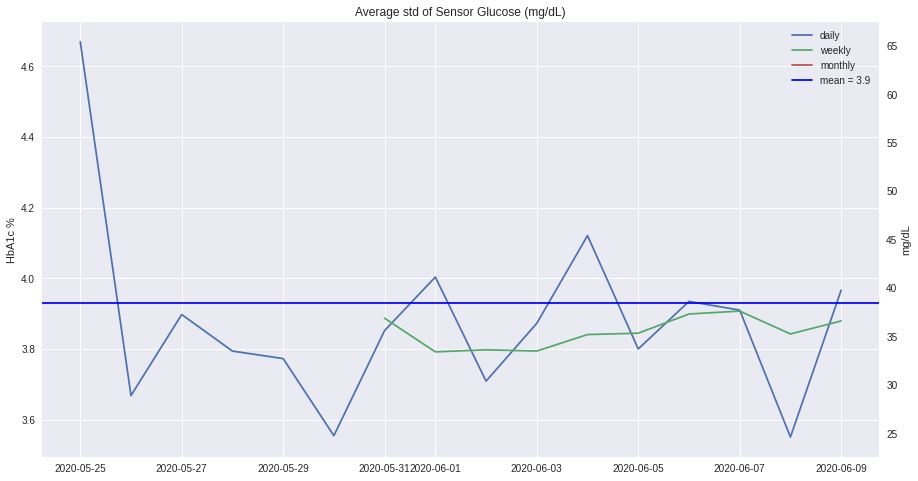

In [18]:
comparative_hba1c_plot(data, kind='std')

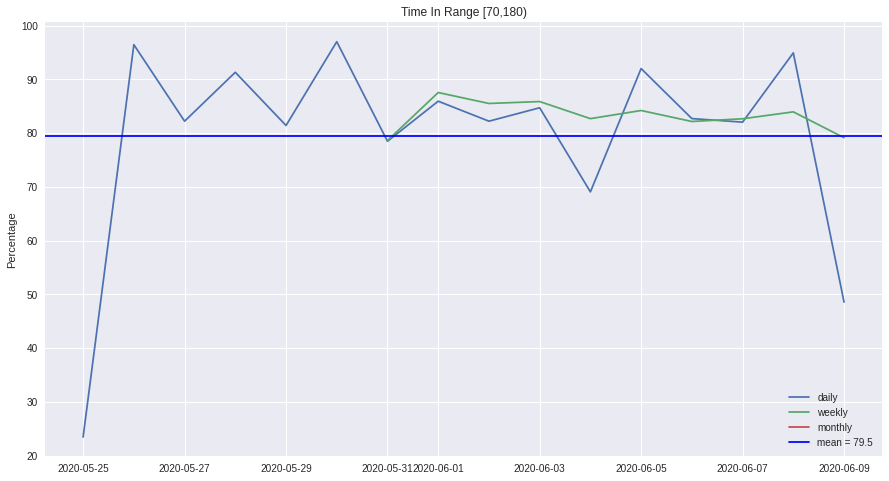

In [19]:
proportions_visualiser(data, kind="tir")

In [66]:
"""
export = data["2020-06-01":"2020-06-09"].copy()
export["Sensor Glucose (mg/dL)"].plot()
plt.figure()
export["Basal Rate (U/h)"].plot()
"""

'\nexport = data["2020-06-01":"2020-06-09"].copy()\nexport["Sensor Glucose (mg/dL)"].plot()\nplt.figure()\nexport["Basal Rate (U/h)"].plot()\n'

In [64]:
"""
with open("preproc.toml", "r") as f:
    config = toml.load(f, _dict=objdict)
config.interpolation.specs
"""

'\nwith open("preproc.toml", "r") as f:\n    config = toml.load(f, _dict=objdict)\nconfig.interpolation.specs\n'

In [61]:
# Visualise changes : 
"""
new_hybrid_interpolator(export["Sensor Glucose (mg/dL)"], **config.interpolation.specs).plot(label="interpolated")
export["Sensor Glucose (mg/dL)"].plot(label="original")
plt.legend()
plt.figure()
export["Basal Rate (U/h)"].plot(label="Basal")
plt.legend()
plt.figure()
export["BWZ Carb Ratio (g/U)"].fillna(method="ffill").plot(label="Ratio")
plt.legend()
"""

'\nnew_hybrid_interpolator(export["Sensor Glucose (mg/dL)"], **config.interpolation.specs).plot(label="interpolated")\nexport["Sensor Glucose (mg/dL)"].plot(label="original")\nplt.legend()\nplt.figure()\nexport["Basal Rate (U/h)"].plot(label="Basal")\nplt.legend()\nplt.figure()\nexport["BWZ Carb Ratio (g/U)"].fillna(method="ffill").plot(label="Ratio")\nplt.legend()\n'

In [62]:
"""
export["Sensor Glucose (mg/dL)"] = new_hybrid_interpolator(
    export["Sensor Glucose (mg/dL)"], 
    **config.interpolation.specs
)
export["BWZ Carb Ratio (g/U)"] = export["BWZ Carb Ratio (g/U)"].fillna(method="ffill")
export[["Sensor Glucose (mg/dL)", "BWZ Carb Ratio (g/U)", "Basal Rate (U/h)"]].to_csv("multivariate_diabetic.csv")
"""

'\nexport["Sensor Glucose (mg/dL)"] = new_hybrid_interpolator(\n    export["Sensor Glucose (mg/dL)"], \n    **config.interpolation.specs\n)\nexport["BWZ Carb Ratio (g/U)"] = export["BWZ Carb Ratio (g/U)"].fillna(method="ffill")\nexport[["Sensor Glucose (mg/dL)", "BWZ Carb Ratio (g/U)", "Basal Rate (U/h)"]].to_csv("multivariate_diabetic.csv")\n'

In [199]:
dates = pd.unique(data.index.date)
n_total = len(dates)
print(f"Number of days in data : {len(dates)}")

Number of days in data : 16


In [214]:
n_month = 30
n_latest = 4
#month = data.loc[dates[len(dates) - n_month]:dates[-1], :] if n_month < n_total else None
latest = data.loc[dates[len(dates)- n_latest]:dates[-1], :] if n_latest < n_total else None
lday = data.loc[dates[len(dates)- 1]:dates[-1], :] if n_latest < n_total else None

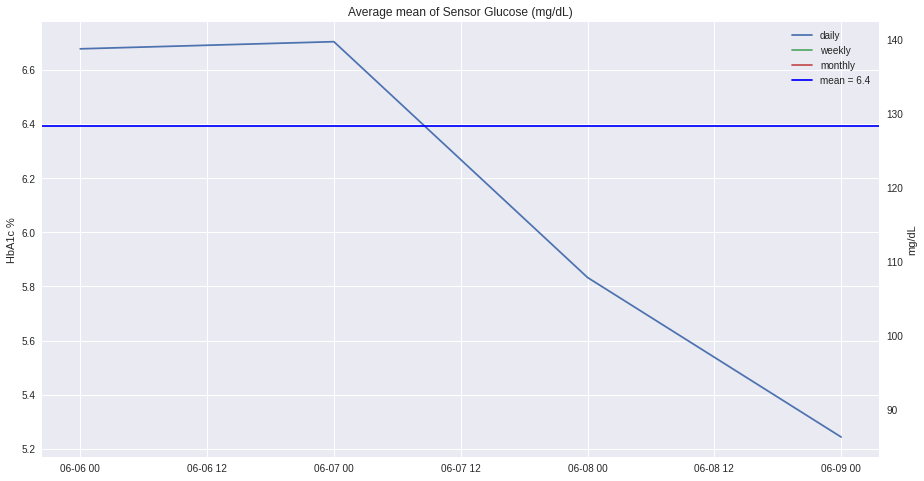

In [207]:
#comparative_hba1c_plot(month)
plt.figure()
comparative_hba1c_plot(latest)

In [205]:
# maybe we should interpolate grouping by day ?

In [221]:
#latest.loc["2020-04-15", "Sensor Glucose (mg/dL)"].interpolate().plot()
#latest.loc["2020-04-15", "Sensor Glucose (mg/dL)"].plot()
latest.columns

Index(['New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'Preset Bol

In [198]:
"""
sns.scatterplot(
    data=latest,
    x="minutes",
    y="Sensor Glucose (mg/dL)",
    hue=latest.index.date,
    size="d30"
)
"""

'\nsns.scatterplot(\n    data=latest,\n    x="minutes",\n    y="Sensor Glucose (mg/dL)",\n    hue=latest.index.date,\n    size="d30"\n)\n'

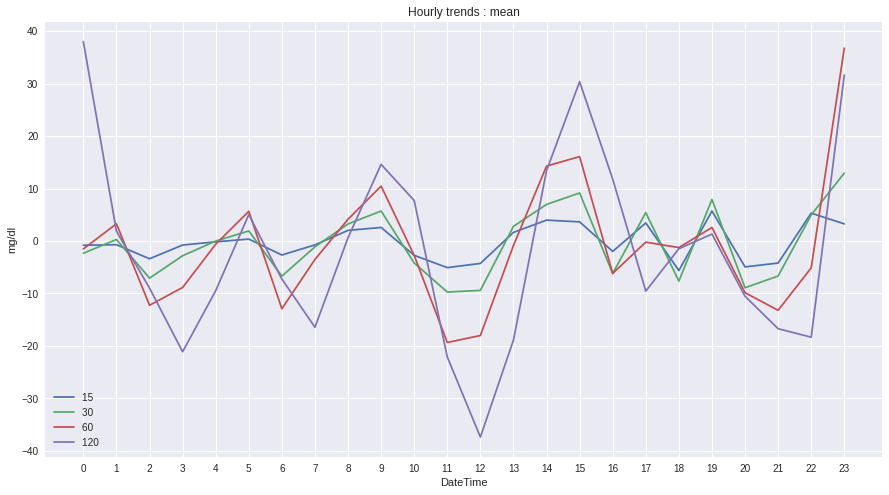

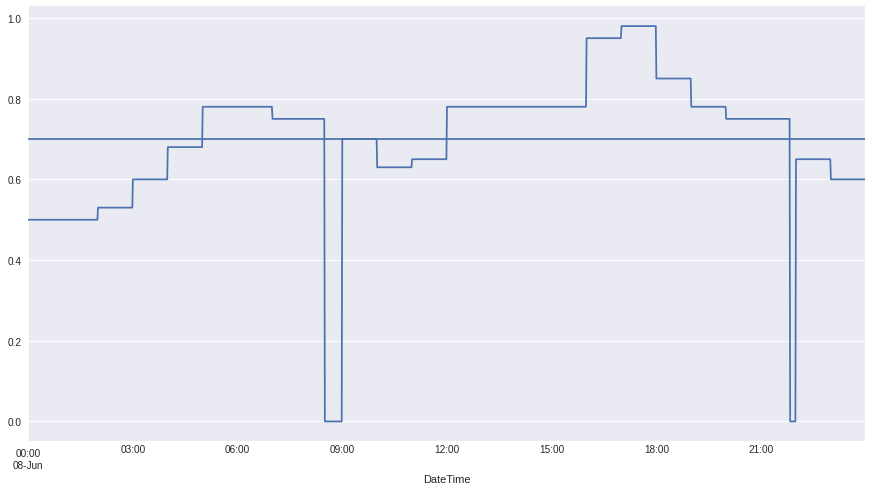

In [224]:
hourly_trends(latest, kind="mean")
plt.figure()
debasal = latest.loc[str(dates[-2]),"Basal Rate (U/h)"]
debasal.plot()
plt.axhline(debasal.mean())

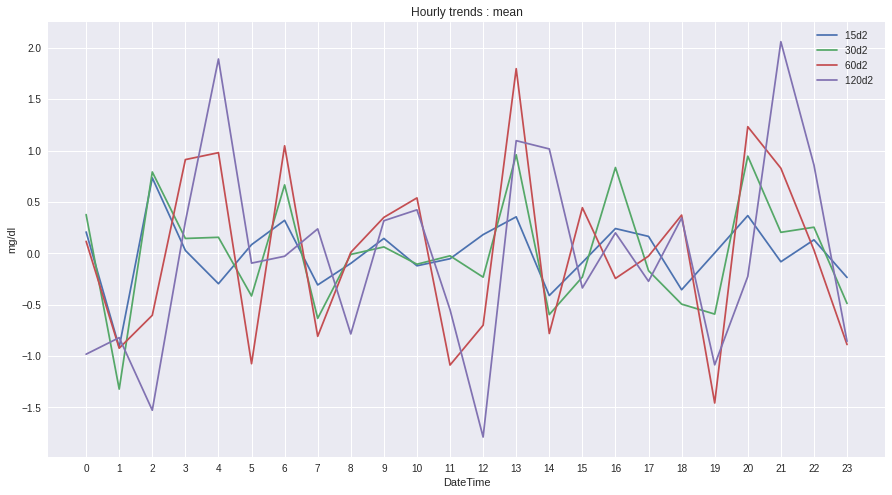

In [36]:
hourly_trends(latest, kind="mean", deltas=["15d2", "30d2", "60d2", "120d2"])

In [89]:
latest["Basal Rate (U/h)"].describe()

count    4321.000000
mean        0.710278
std         0.192548
min         0.000000
25%         0.630000
50%         0.750000
75%         0.780000
max         1.310000
Name: Basal Rate (U/h), dtype: float64

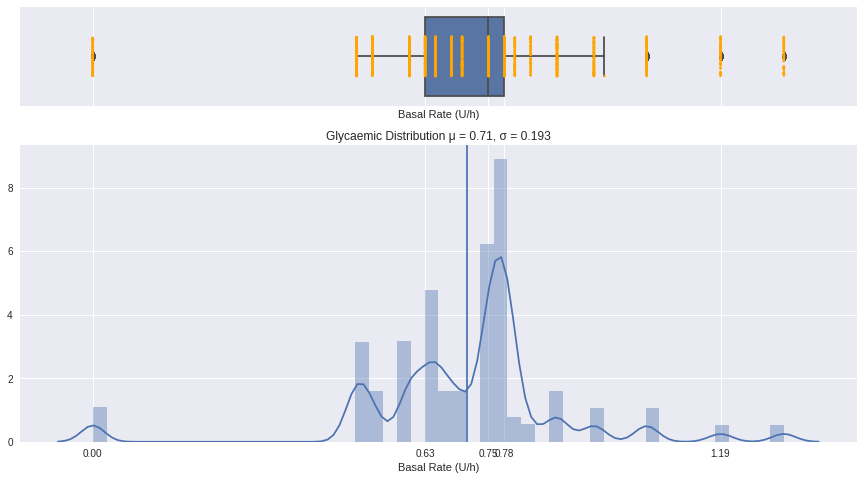

In [94]:
dist_plot(latest["Basal Rate (U/h)"], sig=3)

In [40]:
#hourly_trends(basal, kind="std")

In [79]:
basal = basal_only(latest)

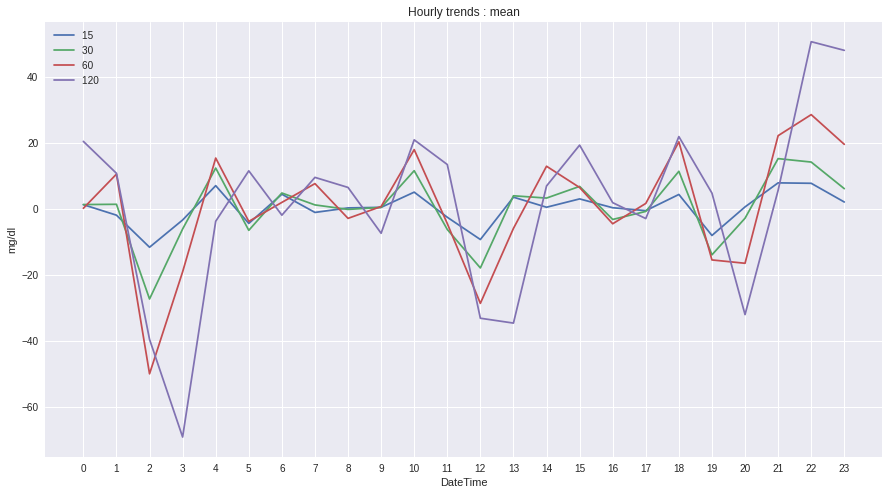

In [80]:
hourly_trends(basal)

In [81]:
#hourly_trends(basal, kind="std")

In [82]:
bar = nonull_indices(latest, "BWZ Carb Input (grams)")

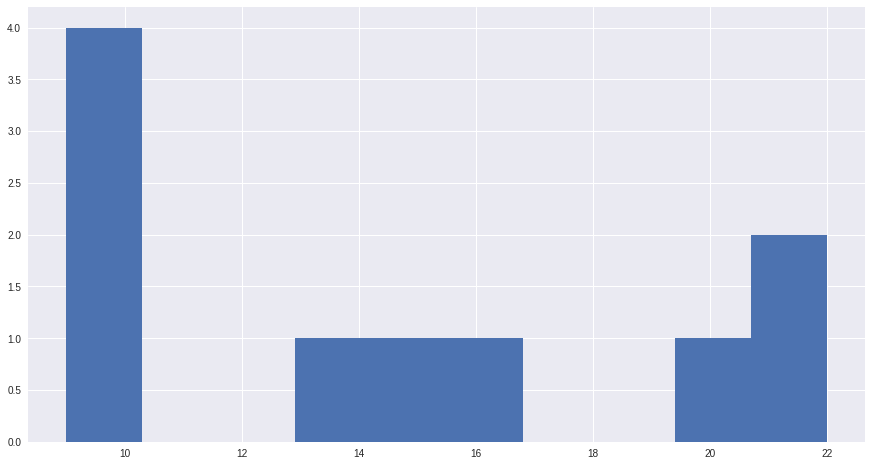

In [83]:
bar.hour.to_series().hist()

In [84]:
foo = nonull_indices(latest, "BWZ Correction Estimate (U)")

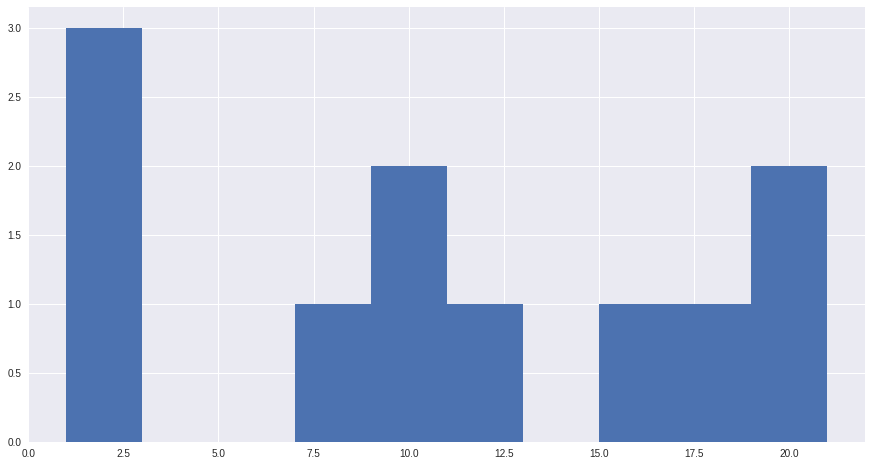

In [85]:
foo.hour.to_series().hist()